# ManualAIze development

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [3]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")


In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Certification - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Set up Qdrant

In [5]:
import glob
import time
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Get all PDF files in the data directory
pdf_files = glob.glob("./data/*.pdf")
print(f"Found {len(pdf_files)} PDF files:")
for file in pdf_files:
    print(f"  - {file}")

# Load all PDF files with PyPDF (much faster!)
all_documents_pypdf = []
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

for pdf_file in pdf_files:
    try:
        print(f"\nLoading {pdf_file}...")
        start_time = time.time()
        
        # PyPDFLoader is MUCH faster than UnstructuredPDFLoader
        loader = PyPDFLoader(pdf_file)
        pages = loader.load()
        
        # Split into smaller chunks for better retrieval
        documents = text_splitter.split_documents(pages)
        
        elapsed = time.time() - start_time
        all_documents_pypdf.extend(documents)
        print(f"✓ Loaded {len(pages)} pages → {len(documents)} chunks in {elapsed:.1f}s")
        
    except Exception as e:
        print(f"✗ Error loading {pdf_file}: {e}")

print(f"\nTotal documents: {len(all_documents_pypdf)}")

Found 3 PDF files:
  - ./data/2024-odyssey.pdf
  - ./data/foonf_2024_manual_US_EN_02_27_2024_WEB_Final.pdf
  - ./data/2022-mazda-mazda6.pdf

Loading ./data/2024-odyssey.pdf...
✓ Loaded 702 pages → 1210 chunks in 23.2s

Loading ./data/foonf_2024_manual_US_EN_02_27_2024_WEB_Final.pdf...
✓ Loaded 100 pages → 143 chunks in 3.2s

Loading ./data/2022-mazda-mazda6.pdf...
✓ Loaded 702 pages → 1466 chunks in 10.8s

Total documents: 2819


In [6]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    all_documents_pypdf,
    embeddings,
    location=":memory:",
    collection_name="Manuals"
)

## RAG
let's start by setting up a RAG loop

In [7]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

In [8]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

In [9]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Be concise and to the point. Explain your answer in a way that is easy to understand. 

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

In [10]:
HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. 
Only use the provided context to answer the query. 
If you do not know the answer, or it's not contained in the provided context respond with "I don't know"

Be concise and to the point. Explain your answer in a way that is easy to understand. 
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [ ]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")


### Build the RAG loop

In [12]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
    question: str
    context: list[Document]
    response: str

def retrieve(state: State) -> State:
    retrieved_docs = compression_retriever.invoke(state["question"])
    return {"context": retrieved_docs}

def generate(state: State) -> State:
    generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
    response = generator_chain.invoke({"query": state["question"], "context": state["context"]})
    return {"response": response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

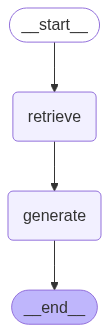

In [13]:
rag_graph

In [14]:
rag_graph.invoke({"question" : "What are the front facing height and weight limits for the car seat?"})

{'question': 'What are the front facing height and weight limits for the car seat?',
 'context': [Document(metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign CC 2017 (Windows)', 'creationdate': '2024-02-27T10:43:44-05:00', 'moddate': '2024-02-28T00:09:55-05:00', 'trapped': '/False', 'source': './data/foonf_2024_manual_US_EN_02_27_2024_WEB_Final.pdf', 'total_pages': 100, 'page': 17, 'page_label': '15', '_id': '167c225c26a546af9a80b9da86c7b75c', '_collection_name': 'Manuals', 'relevance_score': 0.75312227}, page_content='15\n  When Using This Car Seat \nin Forward-Facing Mode\nP Child’s weight is between 22 and 65 lb \n(10 and 29.5 kg).\nP Child’s height is between 30 and 49 in. \n(76 and 124 cm).\nP Child is at least 1 year of age.\nP Car seat is securely installed in a rear \nvehicle seating position using either the \nrigid LATCH Connectors and the Top \nTether; the vehicle belt and Top Tether; or \nthe rigid LATCH Connectors, the vehicle \nbelt, and the Top Te

### Helper functions
Let's create the helper functions to create the agents

In [15]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent node helper
An helper function to help us wrap agents into nodes. We want to initialize the agent state, pass the agent node/object and assign it a name to display in the trace

In [16]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    # Extract the actual output text from the agent result
    if isinstance(result, dict):
        output_text = result.get('output', str(result))
    else:
        output_text = str(result)
    
    # Return two messages: one identifying the agent, one with its response
    return {
        "messages": [
            HumanMessage(content=f"{name} agent responding:"),
            AIMessage(content=output_text, name=name)
        ]
    }

### Agent Creation helper
We will have to create multiple agents, so let's create a function to help us with populating the agent nodes. We will have our helper accepts the following parameters:

- llm: the llm that will power this agent node
- tools: the list of tools available to the llm
- system_prompt: the system prompt to attach to the llm to ground its generation


In [17]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Editor Helper Function
An helper function to create an editor agent that whether the answer provided by the RAG agent is enough or if it needs extra context from an online research. 

It takes the llm object, the system prompt and then the list of member nodes

In [18]:
def create_editor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    
    tool_def = {
        "type": "function",
        "function": {
            "name": "route",
            "description": "Select the next role.",
            "parameters": {
                "type": "object",
                "properties": {
                    "next": {
                        "type": "string",
                        "enum": options,
                    },
                },
                "required": ["next"],
            },
        }
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    
    
    return (
        prompt
        | llm.bind_tools([tool_def], tool_choice={"type": "function", "function": {"name": "route"}})
        | JsonOutputFunctionsParser()
    )

### Create the tool belt

In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
]

/var/folders/6m/hq4dj_jn0l96rctpr1_nhgyr0000gn/T/ipykernel_50811/3644306814.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


In [20]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(query: Annotated[str, "Query to ask the retrieve information tool"]):
    """Use Retrieval Augmented Generation to retrieve information about the user query"""
    return rag_graph.invoke({"question": query})

## Set up the Retrieval team
We first need to define what state we want to keep track of during the execution.
- messages: The messages we've done so far
- team_members: which team members we have access to
- next: what team member is up next

In [21]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class RetrievalTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

### Let's define the LLM of the Retrieval team
The orchestrator that will decide which tools to call, whether RAG or tavily, and when to finish the retrieval part

In [22]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


#### Online search agent

In [23]:
search_agent = create_agent(
    llm, 
    tool_belt, 
    "You are a research assistant who can search for details to asnwer the user query."
    )
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### RAG agent

In [24]:
rag_agent = create_agent(
    llm, 
    [retrieve_information],
    "You are a research assistant who can provide specific information on the topic specified in the context.",
    )
rag_node = functools.partial(agent_node, agent=rag_agent, name="RAG")

#### Retrieval team supervisor agent

In [25]:
editor_agent = create_editor(
    llm,
    ("You are an expert senior technical editor tasked with writing an easy to understand answer to a user question. You already received a draft of the answer"
    " from a retrieval assistant. You need to review the draft and make sure it is easy to understand and accurate."
    " If the answer does not answer the user question, you need to ask the Search assistant to find more information online about the query."
    " The worker will perform a task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search"],
)

### Create the graph
Connect the nodes. The entrypoint should be the supervisor

In [26]:
retrieval_graph = StateGraph(RetrievalTeamState)

retrieval_graph.add_node("Search", search_node)
retrieval_graph.add_node("RAG", rag_node)
retrieval_graph.add_node("Editor", editor_agent)

retrieval_graph.set_entry_point("RAG")
retrieval_graph.add_edge("RAG", "Editor")
retrieval_graph.add_edge("Search", "Editor")
retrieval_graph.add_conditional_edges(
    "Editor",
    lambda x: x["next"],
    {
        "Search": "Search",
        "FINISH": END,
    }
)

compiled_retrieval_graph = retrieval_graph.compile()

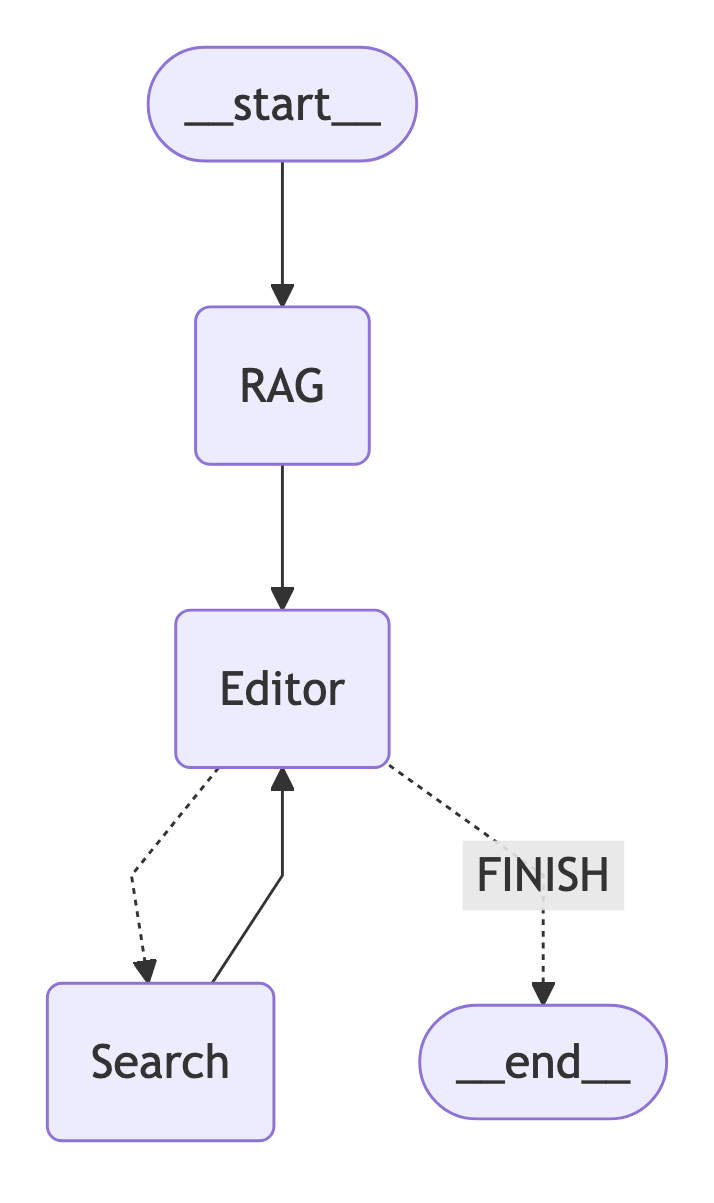

In [27]:
import nest_asyncio
nest_asyncio.apply()

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_retrieval_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)


### Let's create the conveyor belt and connect to it

If we imagine an agent as a factory, where the raw materials are the user question and the final product is the final LLM answer, we then can consider each agent as a highly specialized machine that takes raw products and processes them. Once we build each machine, then in order to have a assembly line, we need to create a delivery system to connect each tool. This is what chaining does! We create the conveyor belt by defininf an `enter_chain` function that extracts the materials needed by this tool (instruction prompt) and connect it to each tool. Because here we are talking about the retrieval agent which is the first agent our supervisor will call, we want to extract the query asked by the human

In [28]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | compiled_retrieval_graph

In [29]:
for s in research_chain.stream(
    "What is the weight and height limits for the car seat when front facing?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'RAG': {'messages': [HumanMessage(content='RAG agent responding:', additional_kwargs={}, response_metadata={}), AIMessage(content='The weight limit for front-facing car seats is between 22 and 65 lb (10 and 29.5 kg), and the height limit is between 30 and 49 in. (76 and 124 cm). Additionally, the child should be at least 1 year of age to use the car seat in this mode.', additional_kwargs={}, response_metadata={}, name='RAG')]}}
---


OutputParserException: Could not parse function call: 'function_call'
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 